In [1]:
# test reading in 10x data with AnnData
import pandas as pd
import numpy as np
import scanpy as sc
from glob import glob
import os
import scvi
import pickle
from scipy import sparse
import anndata as ad

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_palette(sns.color_palette("Spectral"))
sns.set_style("whitegrid")

from matplotlib.ticker import StrMethodFormatter
# ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.2f}"))

import requests
from tqdm import tqdm

In [2]:
data_dir = "data"

In [17]:
gsm_dict = {}

for root, folders, _ in os.walk(data_dir):
    for i in folders:
        if i.startswith("GSM"):
            gsm_dict[i.split("_")[0]] = os.path.join(root,i)

# linux has different delimiters:
def detect_delimiter(path):
    if '/' in path:
        return '/'
    elif '\\' in path:
        return '\\'
    else:
        return None  # No delimiter found


gse_dict = {key : value.split(detect_delimiter(value))[1] for key, value in gsm_dict.items()}

# returns full path from GSM number
def gsm_path(gsm):
    return gsm_dict["GSM" + str(gsm)]

# returns anndata object of 10x data
def read_dir(gsm_code, **kwargs):
    data_path = gsm_path(gsm_code)
    matrix_path = os.path.join(data_path, 'matrix.mtx')
    barcodes_path = os.path.join(data_path, 'barcodes.tsv')
    features_path = os.path.join(data_path, 'features.tsv')
    
    adata = sc.read_mtx(matrix_path)
    adata_bc = pd.read_csv(barcodes_path, header=None, delimiter = "\t")
    adata_features = pd.read_csv(features_path, header=None, delimiter = '\t')
    
    adata = adata.T

    adata.obs['cell_id'] = adata_bc[0].values

    # gene ids
    adata.var['symbol'] = adata_features[1].values

    # make ensembl id the gene index since it is unique
    adata.var_names = adata_features[0].values

    # Each cell gets unique name
    adata.obs_names = [f"cell_{i:d}" for i in range(adata.n_obs)]
    
    adata.obs["GSM"] = gsm_code

    # GSE is batch key
    adata.obs["batch"] = gse_dict["GSM"+str(gsm_code)][3:]
    
    # kwargs contain sample wide data
    for key, value in kwargs.items():
        adata.obs[key.upper()] = value
    
    return adata


# saves as pickle
def save_pickle(adata_obj, gsm_code):
    try:
        with open("preprocessing/pickles/{}.pkl".format(gsm_code), "wb") as File:
            pickle.dump(adata_obj, File)
    except Exception as e:
        print(e)


In [18]:
gsm_dict

{'GSM4679492': 'data\\GSE154775\\GSM4679492_HS1',
 'GSM4679493': 'data\\GSE154775\\GSM4679493_HS2',
 'GSM4679494': 'data\\GSE154775\\GSM4679494_181009_HS_lesional_epi',
 'GSM4679495': 'data\\GSE154775\\GSM4679495_181009_HS_lesional_dermis',
 'GSM4679496': 'data\\GSE154775\\GSM4679496_HSEpi190103',
 'GSM4679497': 'data\\GSE154775\\GSM4679497_HSDerm190103',
 'GSM4679498': 'data\\GSE154775\\GSM4679498_HSEpi190115',
 'GSM4679499': 'data\\GSE154775\\GSM4679499_HSDerm190115',
 'GSM4679500': 'data\\GSE154775\\GSM4679500_HS_07_2018-06-29',
 'GSM4712970': 'data\\GSE155850\\GSM4712970_Healthy_2',
 'GSM4712971': 'data\\GSE155850\\GSM4712971_HS_1',
 'GSM4712972': 'data\\GSE155850\\GSM4712972_HS_2',
 'GSM7754887': 'data\\GSE155850\\GSM7754887_Healthy1KC',
 'GSM7754888': 'data\\GSE155850\\GSM7754888_Healthy2KC',
 'GSM7754889': 'data\\GSE155850\\GSM7754889_HS1KC',
 'GSM7754890': 'data\\GSE155850\\GSM7754890_HS2KC',
 'GSM5352392': 'data\\GSE175990\\GSM5352392_HS_1',
 'GSM5352393': 'data\\GSE175990\\GS

In [7]:
s = pd.Series(gse_dict)

flipped = pd.Series(s.index, index=s.values)

flipped.to_excel("sample_list.xlsx")

In [256]:
def preprocess(sample_code, **kwargs):
    HS1 = read_dir(sample_code, **kwargs)

    output_dir = "preprocessing/GSM{}".format(str(sample_code))

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    ## add gene labels to features

    # mitochondrial genes
    HS1.var["mt"] = HS1.var["symbol"].str.startswith("MT-")

    # ribosomal genes
    HS1.var["ribo"] = HS1.var["symbol"].str.startswith(("RPS","RPL"))

    # hemoglobin genes
    HS1.var["hb"] = HS1.var["symbol"].str.contains("^HB[^(P)]")

    # output cell counts 
    qc_counts = HS1.var[["mt","ribo","hb"]].apply(sum, axis = 0)
    qc_counts["total pre-qc cells"] = HS1.n_obs
    qc_counts["total pre-qc genes"] = HS1.n_vars
    

    # calculate qc metrics
    sc.pp.calculate_qc_metrics(
    HS1,
    qc_vars = ["mt","ribo","hb"],
    inplace = True,
    )

    # generate qc violin plot
    ax = sc.pl.violin(
    HS1,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo"],
    jitter=0.4,
    multi_panel=True,
    show = False,
    ax = None
    )
    
    # Set the title for the FacetGrid
    ax.fig.suptitle("GSM {} (n_cells = {})".format(str(sample_code), HS1.n_obs), fontsize=16)  # Adjust fontsize as needed

    ax.axes.flat[0].set_title('Unique Genes Count')
    ax.axes.flat[1].set_title('Total Gene Count')
    ax.axes.flat[2].set_title('Percent Count in Mt Genes')
    ax.axes.flat[3].set_title('Percent Count in Rb Genes')
    ax.axes.flat[0].set_ylabel('')
    ax.axes.flat[1].set_ylabel('')
    ax.axes.flat[2].set_ylabel('')
    ax.axes.flat[3].set_ylabel('')
    # Adjust layout to make room for the title
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    ax.savefig(os.path.join(output_dir,"{}_pre-qc_violin.png".format(str(sample_code))))
    plt.close()


    ## filter cells and genes
    sc.pp.filter_cells(HS1, min_genes = 300)
    sc.pp.filter_cells(HS1, max_genes = 6000)

    # remove cells with mitocondrial dna > 20%
    HS1 = HS1[HS1.obs["pct_counts_mt"] < 20]

    # remove cells with ribosomal dna > 55%
    HS1 = HS1[HS1.obs["pct_counts_ribo"] < 55]

    # remove cells with rna counts > 40000
    HS1 = HS1[HS1.obs["total_counts"] < 40000]

    # remove genes with less than 3 cells
    sc.pp.filter_genes(HS1, min_cells = 3)

    # remove doublets using scanpy.pp.scrublet
    sc.pp.scrublet(HS1, verbose=True)

    print("Percentage Doublets Detected: {}".format(
        sum(HS1.obs["predicted_doublet"])/HS1.n_obs))

    HS1 = HS1[~HS1.obs["predicted_doublet"]]


    # normalize and find varied features after joining do not do it in qc

    # normalize and store raw counts
    # HS1.layers["counts"] = HS1.X.copy()

    # normalize to median counts then lognormalize x' = log(x+1)
    #sc.pp.normalize_total(HS1)
    #sc.pp.log1p(HS1)
    
    # now HS1.X is the lognormalized rna counts

    # get most varied features
    #sc.pp.highly_variable_genes(HS1, n_top_genes=2000, batch_key='GSM', flavor = "seurat_v3")

    #sc.pl.highly_variable_genes(HS1, show = False)
    #plt.savefig(os.path.join(output_dir,"{}_variable_features.png".format(str(sample_code))))

    # generate qc violin plot
    ax = sc.pl.violin(
    HS1,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo"],
    jitter=0.4,
    multi_panel=True,
    show = False,
    ax = None
    )
    
    # Set the title for the FacetGrid
    ax.fig.suptitle("GSM {} (n_cells = {})".format(str(sample_code), HS1.n_obs), fontsize=16)  # Adjust fontsize as needed

    ax.axes.flat[0].set_title('Unique Genes Count')
    ax.axes.flat[1].set_title('Total Gene Count')
    ax.axes.flat[2].set_title('Percent Count in Mt Genes')
    ax.axes.flat[3].set_title('Percent Count in Rb Genes')
    ax.axes.flat[0].set_ylabel('')
    ax.axes.flat[1].set_ylabel('')
    ax.axes.flat[2].set_ylabel('')
    ax.axes.flat[3].set_ylabel('')
    # Adjust layout to make room for the title
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    ax.savefig(os.path.join(output_dir,"{}_post-qc_violin.png".format(str(sample_code))))

    sc.pl.scatter(HS1, "total_counts", "n_genes_by_counts", color="pct_counts_mt", show = False)
    plt.savefig(os.path.join(output_dir,"{}_post-qc_mt_count.png".format(str(sample_code))))
    plt.close()
    
    qc_counts["total post-qc cells"] = HS1.n_obs
    qc_counts["total post-qc genes"] = HS1.n_vars
    qc_counts.to_csv(os.path.join(output_dir,"qc_cell_counts.csv"),header=False)

    save_pickle(HS1, sample_code)

    # save gsm info as html
    response = requests.get("https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM{}".format(str(sample_code)))
     
    if response.status_code == 200:
        # Open a file in write mode
        with open(os.path.join(output_dir,'sample_info.html'), 'w', encoding='utf-8') as file:
            # Write the content of the response to the file
            file.write(response.text)
        print('Sample info saved to output.html')
    else:
        print(f'Failed to retrieve the URL. Status code: {response.status_code}')

In [ ]:
with open("errors.txt","w") as ErrorFile:
    for sample in tqdm(list(gsm_dict.keys())):
        sample_code = int(sample[3:])
        try:
            preprocess(sample_code)
        except:
            ErrorFile.write(sample)
            ErrorFile.write('\n')


In [137]:
# mitochondrial genes
HS1.var["mt"] = HS1.var["symbol"].str.startswith("MT-")

# ribosomal genes
HS1.var["ribo"] = HS1.var["symbol"].str.startswith(("RPS","RPL"))

# hemoglobin genes
HS1.var["hb"] = HS1.var["symbol"].str.contains("^HB[^(P)]")

In [139]:
sc.pp.calculate_qc_metrics(
    HS1,
    qc_vars = ["mt","ribo","hb"],
    inplace = True,
)

# log1p = log(x+1)
# log2 fold change = log_2(new/old)
# pct dropout = percentage of cells with zero expression of gene


c:\Users\randymi\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\randymi\AppData\Local\Temp\ipykernel_12344\2203637646.py:21: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.95])


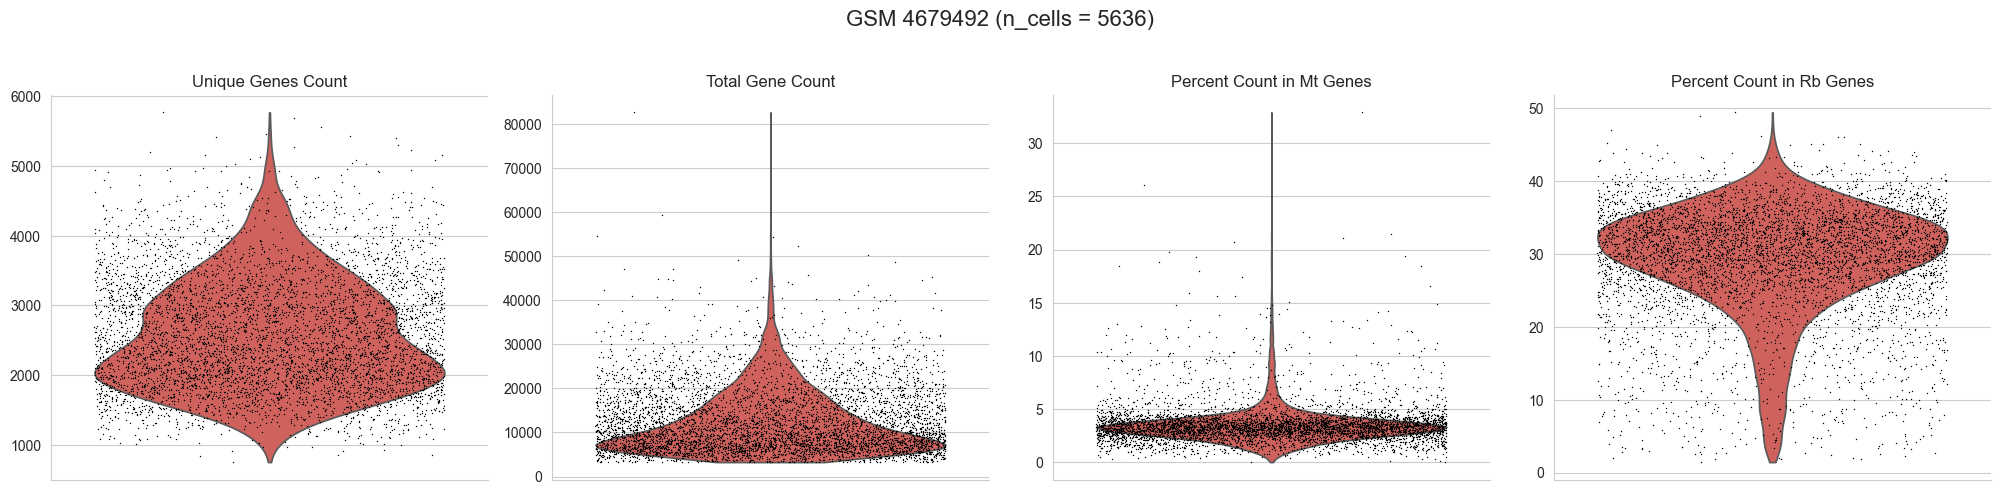

In [140]:
ax = sc.pl.violin(
    HS1,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo"],
    jitter=0.4,
    multi_panel=True,
    show = False,
    ax = None
)
# Set the title for the FacetGrid
ax.fig.suptitle("GSM 4679492 (n_cells = {})".format(HS1.n_obs), fontsize=16)  # Adjust fontsize as needed

ax.axes.flat[0].set_title('Unique Genes Count')
ax.axes.flat[1].set_title('Total Gene Count')
ax.axes.flat[2].set_title('Percent Count in Mt Genes')
ax.axes.flat[3].set_title('Percent Count in Rb Genes')
ax.axes.flat[0].set_ylabel('')
ax.axes.flat[1].set_ylabel('')
ax.axes.flat[2].set_ylabel('')
ax.axes.flat[3].set_ylabel('')
# Adjust layout to make room for the title
plt.tight_layout(rect=[0, 0, 1, 0.95])



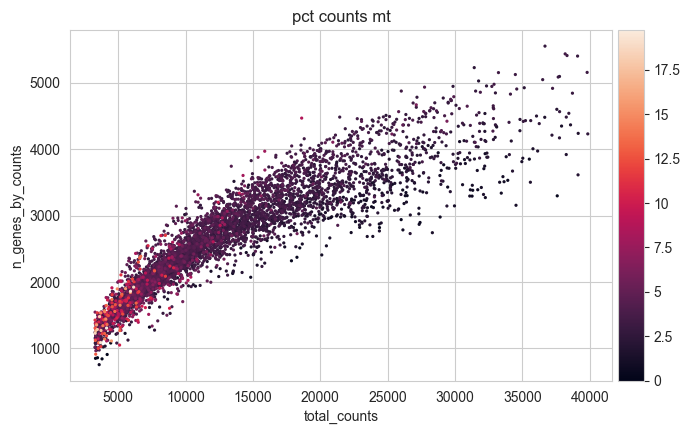

In [237]:
sc.pl.scatter(HS1, "total_counts", "n_genes_by_counts", color="pct_counts_mt", show = False)
plt.savefig("hello.png")

In [78]:
# Preprocessing Steps
1. load data
2. QC, for each sample, filter for cells with:
    a. 300 < Unique Genes < 6000
    b. total RNA count < 40000
    c. Michtocondrial DNA < 20%
    d. Perform doublet detection and drop doublet cells
    e. filter genes expressed in less than 3 cells
    f. normalize
3. Filter genes expressed in less than 3 cells

Text(0.5, 0.15888127824039344, 'bruh')

In [142]:
sc.pp.filter_cells(HS1, min_genes = 300)
sc.pp.filter_cells(HS1, max_genes = 6000)

# remove cells with mitocondrial dna > 20%
HS1 = HS1[HS1.obs["pct_counts_mt"] < 20]

# remove cells with rna counts > 40000
HS1 = HS1[HS1.obs["total_counts"] < 40000]

# remove genes with less than 3 cells
sc.pp.filter_genes(HS1, min_cells = 3)

# remove doublets using scanpy.pp.scrublet
sc.pp.scrublet(HS1, verbose=True)

print("Percentage Doublets Detected: {}".format(
    sum(HS1.obs["predicted_doublet"])/HS1.n_obs))

HS1 = HS1[~HS1.obs["predicted_doublet"]]


c:\Users\randymi\AppData\Local\Programs\Python\Python311\Lib\site-packages\scanpy\preprocessing\_simple.py:282: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


In [154]:
HS1.layers["counts"] = HS1.X.copy()

# normalize to median counts then lognormalize x' = log(x+1)
sc.pp.normalize_total(HS1)
sc.pp.log1p(HS1)

# now HS1.X is the lognormalized rna counts

In [181]:
# saves top 2000 as highly_variable (in var)
sc.pp.highly_variable_genes(HS1, n_top_genes=2000, batch_key='GSM')

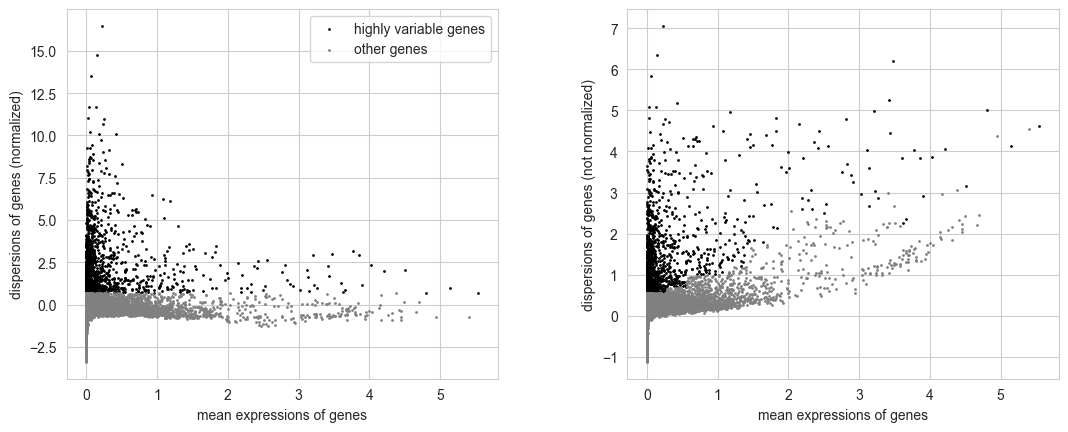

In [209]:
sc.pl.highly_variable_genes(HS1)

In [191]:
def merge_anndata(HSKC1, HS1):
    # Perform the concatenation
    combined_adata = ad.concat(
        [HSKC1, HS1],
        axis=0,
        join='outer',
        merge='first',
        uns_merge='first'
    )
    
    # Combine the symbol information from both datasets
    symbols = pd.concat([HSKC1.var['symbol'], HS1.var['symbol']], axis=1)
    symbols.columns = ['HSKC1_symbol', 'HS1_symbol']
    
    # Use HSKC1 symbols where available, otherwise use HS1 symbols
    combined_symbols = symbols['HSKC1_symbol'].fillna(symbols['HS1_symbol'])
    
    # Update the symbol column in the combined dataset
    combined_adata.var['symbol'] = combined_symbols

    return combined_adata
